In [1]:
from IPython.display import Image

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('/content/drive/MyDrive/머신러닝 교과서 with 파이썬, 사이킷런, 텐서플로/data/housing.data.txt', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

X = df[['RM']].values
y = df['MEDV'].values

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() 

In [3]:
!pip install --upgrade mlxtend

# 10.4 RANSAC을 사용하여 안정된 회귀 모델 훈련

선형 회귀 모델은 이상치(outlier)에 크게 영향을 받을 수 있다. 어떤 상황에서는 데이터의 아주 작은 일부분이 추정 모델의 가중치에 큰 영향을 끼친다.

이상치를 제거하는 방식 대신 RANSAC(RANdom SAmple Consensus) 알고리즘을 사용하여 안정된 회귀 모델을 만들 수 있다. 이 알고리즘은 정상치(inlier)라는 일부 데이터로 회귀 모델을 훈련한다.

* RANSAC 알고리즘
    1. 랜덤하게 일부 샘플을 정상치로 선택하여 모델 훈련
    2. 훈련된 모델에서 다른 모든 포인트를 테스트. 사용자가 입력한 허용 오차 안에 속한 포인트를 정상치에 추가.
    3. 모든 정상치를 사용하여 모델을 다시 훈련.
    4. 훈련된 모델과 정상치 간의 오차를 추정.
    5. 성능이 사용자가 지정한 임계 값에 도달하거나 지정된 반복 횟수에 도달하면 알고리즘 종료. 그렇지 않으면 1부터 다시 반복한다.

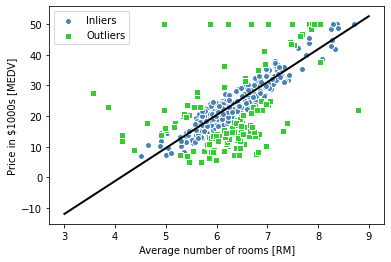

In [4]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100, # 최대 반복 횟수
                         min_samples=50, # 랜덤하게 선택할 샘플의 최소 개수
                         loss='absolute_error', # 'absolute_error' : 학습한 직선과 샘플 포인트 간의 수직 거리의 절대값
                         residual_threshold=5.0, # 학습한 직선과 수직 거리가 5 이내에 있는 정상 샘플만 포함
                         random_state=0)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac= ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

사이킷런에서 정상치 임계 값의 기본값을 MAD 추정이다. MAD는 타깃 값 y의 중앙값 절대 편차(Median Absolute Deviation)를 의미한다. 적절한 정상치 임계 값은 문제에 따라 다르다.(RANSAC의 단점 중 하나)

In [5]:
print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

기울기: 10.735
절편: -44.089


RANSAC을 사용하면 데이터 셋에 있는 이상치의 잠재적인 영향을 감소시킨다. 하지만 이 방법이 새로운 데이터에 대한 예측 성능에 긍정적인 영향을 미치는지 못미치는지는 알지 못한다.

# 10.5 선형 회귀 모델의 성능 평가

In [6]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values # 모든 변수를 사용하여 다변량 회귀 모델
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

모델이 여러 개의 특성을 사용하기 때문에 2차원 그래프로 선형 회귀 직선을 그릴 수 없다. 그 대신 회귀 모델을 조사하기 위해 잔차(실제값과 예측값 사이의 차이 또는 수직거리) 대 예측 값 그래프를 그릴 수 있다.

* 잔차 그래프(residual plot) : 회귀 모델을 진단할 때 자주 사용되는 그래프 도구.
    * 비선형성과 이상치를 감지하고 오차가 랜덤하게 분포되어 있는지를 확인하는 데 도움이 된다.

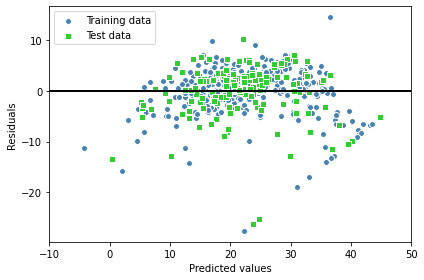

In [7]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2) # y=0 직선
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

* 완벽한 예측의 잔차 = 0 (0에 가까울수록 좋은 모델)
* 좋은 회귀 모델이라면 오차가 랜덤하게 분포되고 잔차는 중앙선 주변으로 랜덤하게 흩어져야 한다.
    * 잔차 그래프에서 패턴이 나타나면 특성에서 어떤 정보를 잡아내지 못하고 잔차로 새어 나갔다고 말한다.(위 그래프에서도 보임)
    * 중앙선에서 큰 편차는 낸 포인트 => 이상치
    

* 평균 제곱 오차(Mean Squared Error, MSE)
    * 선형 회귀 모델을 훈련하기 위해 최소화하는 제곱 오차합(SSE)의 평균
    * 그리드 서치와 교차 검증에서 매개변수를 튜닝하거나 여러 다른 회귀 모델을 비교할 때유용

In [8]:
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

훈련 MSE: 19.958, 테스트 MSE 27.196


* 훈련 데이터셋의 MSE보다 테스트 데이터셋의 MSE가 훨씬 크다 = 과대적합
* 분류 정확도와는 달리 MSE 값에는 제한이 없다.
    * ex) 주택 가격이 1,000 단위로 기록되어 있다면 동일한 모델이 1,000을 곱하지 않은 데이터로 훈련한 모델보다 더 낮은 MSE를 만든다.


* 결정 계수(coefficient of determination, $R^2$)
    * 결정 계수는 모델을 성능을 잘 해석하기 위해 만든 MSE의 표준화된 버전.
    * $R^2$는 타깃의 분산에서 모델이 잡아낸 비율

$$R^2 = 1-\dfrac{SSE}{SST}$$

SSE는 제곱 오차합, SST는 전체 제곱합.

SST = 단순히 타깃의 분산.

훈련데이서세에서 $R^2$은 0과 1사이의 값을 가진다. 테스트 데이터셋에서는 음수가 될 수 있다. $R^2=1$ 이면 MSE는 0이고 모델이 데이터를 완벽히 학습한 것이다.

In [9]:
from sklearn.metrics import r2_score

print('훈련 R2: %.3f, 테스트 R2: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

훈련 R2: 0.765, 테스트 R2: 0.673


# 10.6 회귀에 규제 적용
* 규제 : 부가 정보를 손실에 더해 과대적합 문제를 방지하는 방법
* 복잡도에 대한 패널티(penalty)를 유도하여 모델 파라미터의 값을 감소시킨다
* 릿지 회귀, 라쏘, 엘라스틱 넷
    * 릿지 회귀 : 최소 제곱 비용 함수에 가중치의 제곱합을 추가한 L2 규제 모델
    * 라쏘
        * 희소한 모델을 만들 수 있다
        * 규제 강도에 따라 어떤 가중치는 0이 될 수 있다. 
        * 라쏘를 지도 학습의 특성 선택기법으로 사용할 수 있다.
        * 라쏘의 L1 패널티는 모델의 가중치의 절대값 합으로 정의한다.
        * m > n일 경우(n은 훈련 샘플 개수) 최대 n개의 특성을 선택하는 것이 한계이다.
            * 특성 선택이 필요한 일부 애플리케이션에서는 도움이 되지 않을 수 있지만, 라쏘는 모델이 포화되는 것을 피하기 때문에 종종 실전에서는 라쏘의 성질이 유용하다.
            * 모델 포화 : 훈련 샘플의 개수가 특성 개수와 동일할 때 발생, 과모수화
            * 포화된 모델은 항상 훈련 데이터를 완벽하게 학습하지만 새로운 데이터에서는 단순히 보간만 수행하기 때문에 잘 일반화되지 않는다.
    * 엘라스틱 넷 : 릿지 회귀와 라쏘의 절충안.
        * 희소한 모델을 만들기 위한 L1 패널티와 m>n일 때 n보다 많은 특성을 선택할 수 있는 L2 패털티를 가진다.

하이퍼파라미터 $\lambda$를 사용하여 규제 강도를 지정해야하며, 보통 k-겹 교차 검증으로 최적화한다.


In [10]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# alpha = 규제 강도
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5) # l1_ratio를 1.0으로 설정 시 라쏘 회귀와 동일.

# 10.7 선형 회귀 모델을 다항 회귀로 변환.
* 선형 가정이 어긋날 때 대처할 수 있는 방법 = 다항식 항을 추가한 **다항 회귀 모델**

### 10.7.1 사이킷런을 사용하여 다항식 항 추가
* 사이킷런의 PolynomialFeatures 변환기 클래스

In [11]:
# 1. 이차 다항식 항을 추가
from sklearn.preprocessing import PolynomialFeatures

X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

lr = LinearRegression()
pr = LinearRegression()

quadratic = PolynomialFeatures(degree=2) # 이차(degree=2) 다항식
X_quad = quadratic.fit_transform(X)

In [12]:
# 2. 비교를 위해 평범한 선형 회귀 모델을 훈련
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [13]:
# 3. 다항 회귀를 위해 변환된 특성에서 다변량 회귀 모델을 훈련
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

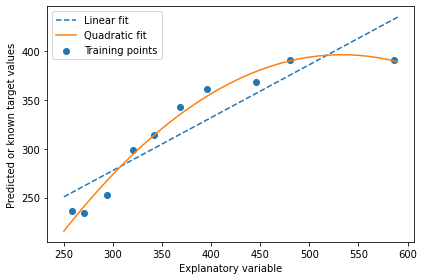

In [14]:
# 4. 결과 그래프
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
# 평가 지표로 MSE과 R2 값 계산
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('훈련 MSE 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('훈련 R^2 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

훈련 MSE 비교 - 선형 모델: 569.780, 다항 모델: 61.330
훈련 R^2 비교 - 선형 모델: 0.832, 다항 모델: 0.982


### 10.7.2 주택 데이터셋을 사용한 비선형 관계 모델링
* 주택 가격과 비선형 상관관계를 가졌던 LSTAT으로 관계 모델링.

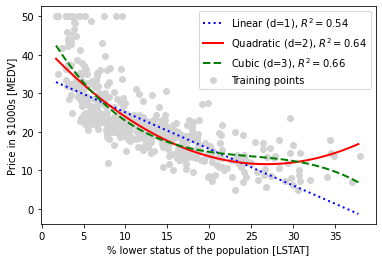

In [16]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# 2차, 3차 다항식 특성
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# 학습된 모델을 그리기 위해 특성 범위를 만든다.
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# 결과 그래프
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='Linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

선형과 이차 다항 모델보다 삼차 다항 모델이 주택 가격과 LSTAT 사이의 관계를 잘 잡아낸다. 하지만 다항 특성을 많이 추가할수록 모델 복잡도가 높아지고 과대적합의 가성성이 증가한다. 실전에서는 별도의 테스트 데이터셋에서 모델의 일반화 성능을 평가하는 것이 권장된다.

다항 특성이 비선형 관계를 모델링하는데 언제나 최선의 선택은 아니다. MEDV-LSTAT 산점도를 보면 로그 스케일로 변환한 LSTAT 특성과 MEDV의 제곱근은 선형 회귀 모델에 적합한 특성 공간을 구성할 것으로 추측할 수 있다.(두 변수 사이의 관계가 지수 함수와 매우 비슷)

$$f(x)=e^{-x}$$

지수 함수에 자연 로그를 취하면 직선이 되기 때문에 로그 변환을 적용하는 것이 좋다.

$$log(f(x))=-x$$


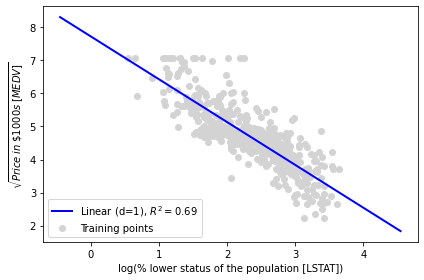

In [17]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# 특성 변환
X_log = np.log(X) # 특성을 로그 스케일로 변환
y_sqrt = np.sqrt(y) # 타깃 값의 제곱근 => 두 변수 사이에서 선형 회귀 관계를 잡을 수 있다.

# 학습된 모델을 그리기 위한 특성 범위
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# 결과 그래프
plt.scatter(X_log, y_sqrt, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='Linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

다른 다항 특성변환보다 이 데이터에서 학습한 선형 모델($R^2=0.69$)이 나아 보인다.

# 10.8 랜덤 포레스트를 사용하여 비선형 관계 다루기
* 랜덤 포레스트
    * 여러 개의 결정 트리를 앙상블한 것으로, 개별 선형 함수의 합.
    * 결정 트리 알고리즘으로 입력 공간을 학습하기 좋은 더 작은 영역으로 분할.

### 10.8.1 결정 트리 회귀
* 결정 트리 알고리즘
    * 장점
        * 비선형 데이터를 다룰 때 특성 변환 필요 X
    * 가중치가 적용된 특성 조합을 고려하는 것이 아닌 한 번에 하나의 특성만 평가
        * 특성 정규화나 표준화가 필요없는 이유
    * 리프 노드가 순수 노드가 되거나 종료 기준을 만족할 때까지 반복적으로 노드 분할
    * 분류에서 결정 트리를 사용할 때 **정보 이득**(IG)이 최대화되는 특성 분할을 결정하기 위해 불순도 지표로 엔트로피 정의.
        * 정보 이득을 최대화하는 특성 분할을 찾는 것이 목적
        * 자식 노드에서 불순도가 최대로 감소되는 특성 분할을 찾아야 한다
    * 결정 트리 회귀에서의 MSE를 종종 **노드 내 분산**(within-node variance)이라고 한다.
        * 분할 기준을 **분산 감소**(variance reduction)이라고 많이 부른다.


In [18]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return

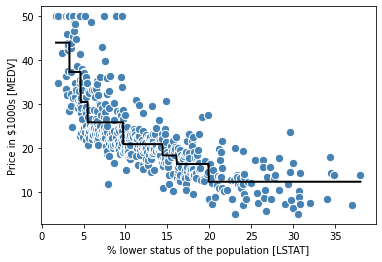

In [19]:
# 사이킷런의 DecisionTreeRegressor로 MEDV와 LSTAT 변수 간의 비선형 관계 모델링
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

결정 트리는 데이터에 있는 일반적인 경향을 잡아낸다. 기대하는 예측이 연속적이고 매끄러운 경우를 나타내지 못하는 것이 결정 트리의 한계이다. 또 데이터에 과대적합되거나 과소적합되지 않도록 적절한 트리의 깊이를 주의 깊게 선택해야 한다.

### 10.8.2 랜덤 포레스트 회귀
* 일반적으로 단일 결정 트리보다 더 나은 일반화 성능을 낸다.
    * 무작위성이 모델의 분산을 낮추어 주기 때문.
* 랜덤 포레스트는 데이터셋에 있는 이상치에 덜 민감하고 하이퍼파라미터 튜닝이 많이 필요하지 않다.
* 일반적으로 랜덤 포레스트에서 튜닝할 유일한 하이퍼파라미터는 앙상블의 트리 개수이다.
* 타깃 값의 예측은 모든 결정 트리의 예측을 평균하여 계산.

In [20]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='squared_error',
                               random_state=1,
                               n_jobs=-1)

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 1.644, 테스트 MSE: 11.085
훈련 R^2: 0.979, 테스트 R^2: 0.877


랜덤 포레스트는 훈련 데이터에 과대적합되는 경향을 볼 수 있다. 하지만 타깃과 특성 간의 관계를 비교적 잘 설명하고 있다.

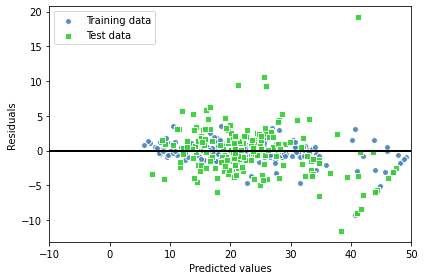

In [22]:
# 예측 잔차 확인
plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=35, alpha=0.9,
            label='Training data')

plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='limegreen',
            edgecolor='white',
            marker='s',
            s=35, alpha=0.9,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])

plt.tight_layout()
plt.show()

이미 $R^2$ 결정 계수에서 나타났듯이 모델이 테스트 데이터보다 훈련 데이터에 잘 맞는다. 잔차 그래프를 보면 y축 방향으로 테스트 데이터셋에 이상치가 보인다. 또 잔차의 분포가 0을 중심으로 완전히 랜덤하지 않아 보인다. 이는 모델이 특성의 정보를 모두 잡아낼 수 없다는 것을 나타낸다.

이상적으로는 모델의 오차가 랜덤하거나 예측할 수 없어야 한다. 즉, 예측 오차가 특성에 담긴 어떤 정보와도 관계가 없어야 한다. 분포나 패턴의 무작위성을 반영해야 한다. 잔차 그래프를 조사하여 예측 오차에 패턴이 감지되면 잔차 그래프가 예측 정보를 담고 있다는 의미이다. 일반적으로 특성의 정보가 잔차로 누설되는 것이 원인이다.

가용한 데이터에 따라 특성을 변환하거나 학습 알고리즘의 하이퍼파라미터를 튜닝하여 모델을 향상시킬 수 있다. 또는 더 간단하거나 더 복잡한 모델을 선택할 수 있고, 이상치를 제외하거나 추가적인 특성을 포함하여 모델의 성능을 높일 수 있다.